In [ ]:
#Verifying GPU...
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#Downloading the dataset...
!wget 'https://www.dropbox.com/s/g7fw12c85f900x4/train.csv'
!wget 'https://www.dropbox.com/s/qo0pxbun34twmrh/test.csv'

### **Data Gathering**

In [ ]:
#Importing required packages...
import numpy as np
import pandas as pd

In [ ]:
#Reading the Train and Test file.
train_file= pd.read_csv('/content/train.csv')
test_file= pd.read_csv('/content/test.csv')

In [ ]:
train_file.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
train_file.shape

(200000, 202)

**Here we see that the features are mostly PC components (except ID_code feature) where we cannot get a description of any PC variable nor we can engineer with.**

### **Exploratory Data Analysis (EDA)**

Lets visualize our data

In [ ]:
#Importing required packages...
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Target Evaluation')

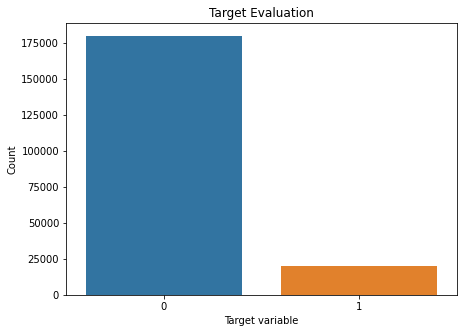

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(x='target', data=train_file)
plt.xlabel('Target variable')
plt.ylabel('Count')
plt.title('Target Evaluation')

**Here from the above plot we see that our data is highly imbalaced i.e., very less number of customers have made specific transaction.**

**As the data is highly imbalanced, we need to balance the data so lets find the class weights**

In [ ]:
unique_classes= list(train_file['target'].unique())
unique_classes

[0, 1]

In [ ]:
out_dict= {}
for classes in unique_classes:
  out_dict[classes]= train_file.shape[0]/((train_file.loc[train_file['target']==classes].shape[0]) * (len(unique_classes)))

out_dict

{0: 0.5558581894587052, 1: 4.975619464623346}

In [ ]:
train_file.isna().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

**From above we see that none of the varaibles have missing values. As our data is scaled and doesn't have any missing values we are good to go with this data.**

**Lets try to see if have any correlated variables in our dataset. If yes, then we would remove it.**

In [ ]:
correlated_features = set()
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.1:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [ ]:
correlated_features

set()

**From above, we see that we dont have any correlated variables i.e., they are independent from each other.**

### **Model Building**

### **Logistic Regression**

In [ ]:
#Importing required packages...
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

In [ ]:
lr= LogisticRegression(class_weight={0: 0.5558581894587052, 1: 4.975619464623346})  #These class weight ratio has been taken from the above where we calculated

**Splitting the data into Train and Test**

In [ ]:
X= train_file.drop(train_file.iloc[:,0:2], axis=1)
Y= train_file['target']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=20)

In [ ]:
lr.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0,
                   class_weight={0: 0.5558581894587052, 1: 4.975619464623346},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:
train_score= lr.predict_proba(X_train)[:,1]
real= Y_train

**Finding Threshold Frequency cutoff**

In [ ]:
fpr, tpr, thresholds = roc_curve(real, train_score)

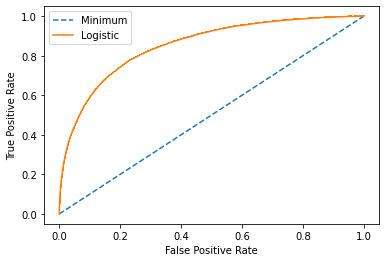

In [ ]:
plt.plot([0,1], [0,1], linestyle='--', label='Minimum')
plt.plot(fpr, tpr, marker=',', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

**Here we will use G-Mean which is a metric for imbalance classification that, if optimized, will seek a balance between the Sensitivity and Specificity.**



> Sensitivity = True Positive Rate(TPR)

> Specificity = 1 - False Positive Rate(FPR)

> G-Mean = sqrt(Sensitivity* Specificity)

In [ ]:
#Calculate gmean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [ ]:
#Locate the index of the largest G-Mean
ix = np.argmax(gmeans)
# print('Best Threshold=%f, G-Mean=%.3f'%(thresholds[ix], gmeans[ix]))

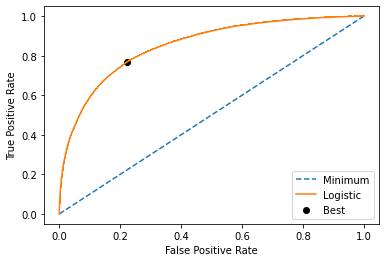

In [ ]:
plt.plot([0,1], [0,1], linestyle='--', label='Minimum')
plt.plot(fpr, tpr, marker=',', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
mycutoff=0.75

**From, above plot we conclude that 0.75 will be our Threshold frequency cutoff score**

In [ ]:
test_score= lr.predict_proba(X_test)[:,1]
Y_pred= (test_score>mycutoff).astype(int)

In [ ]:
cm= confusion_matrix(Y_test, Y_pred)
cm

array([[33720,  2260],
       [ 2111,  1909]])

**Logistic Regression metrics:**

In [ ]:
print('Accuracy is:', accuracy_score(Y_test, Y_pred))
print('ROC_AUC score is', roc_auc_score(Y_test, Y_pred))
print('Precision score is:', precision_score(Y_test, Y_pred))
print('Recall score is:', recall_score(Y_test, Y_pred))

Accuracy is: 0.890725
ROC_AUC score is 0.7060314740914659
Precision score is: 0.4579035739985608
Recall score is: 0.4748756218905473


### **Light GBM**

In [ ]:
#Import required packages...
from lightgbm import LGBMClassifier

In [ ]:
lgb= LGBMClassifier(class_weight= {0: 0.5558581894587052, 1: 4.975619464623346}, metric= 'auc',
                    boosting_type= 'gbdt', objective= 'binary', n_estimators= 1000, learning_rate= 0.05, n_jobs=-1, verbose=1)

In [ ]:
lgb.fit(X_train, Y_train)

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.5558581894587052, 1: 4.975619464623346},
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.05, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=1)

In [ ]:
test_score= lgb.predict_proba(X_test)[:,1]
Y_pred= (test_score>mycutoff).astype(int)

In [ ]:
cm= confusion_matrix(Y_test, Y_pred)
cm

array([[35259,   721],
       [ 2418,  1602]])

**Light GBM metrics:**

In [ ]:
print('Accuracy is:', accuracy_score(Y_test, Y_pred))
print('ROC_AUC score is', roc_auc_score(Y_test, Y_pred))
print('Precision score is:', precision_score(Y_test, Y_pred))
print('Recall score is:', recall_score(Y_test, Y_pred))

Accuracy is: 0.921525
ROC_AUC score is 0.6892342760903652
Precision score is: 0.6896254842875592
Recall score is: 0.39850746268656717


### **Gaussian Naive Bayes**

In [ ]:
#Importing required packages...
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb= GaussianNB()

In [ ]:
gnb.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
test_score= gnb.predict_proba(X_test)[:,1]
Y_pred= (test_score>mycutoff).astype(int)

In [ ]:
cm= confusion_matrix(Y_test, Y_pred)
cm

array([[35865,   115],
       [ 3324,   696]])

**GaussianNB metrics:**

In [ ]:
print('Accuracy is:', accuracy_score(Y_test, Y_pred))
print('ROC_AUC score is', roc_auc_score(Y_test, Y_pred))
print('Precision score is:', precision_score(Y_test, Y_pred))
print('Recall score is:', recall_score(Y_test, Y_pred))

Accuracy is: 0.914025
ROC_AUC score is 0.5849690541179594
Precision score is: 0.8581997533908755
Recall score is: 0.17313432835820897


### ***Important Notes:***



1.   From above we see that we tried 3 different set of algorithms and also tried to handle imbalanced data issue by finding the accurate metrics to balance our data.
2.   Primariy, we ran Linear Regression model where the roc_auc_score was ~70% and Precision and Recall was also quite balanced.
3.   Secondarily, we tried to fit our data using Light GBM. We are using Light GBM because of the following below reasons and the roc_auc_score was  ~68%  with a decent balance between Precision and Recall but not that great as how Linear Regression model has fitted.


              *   It has faster training speed and higher efficiency. We will get better accuracy.
              *   It is capable of handling large-datasets and is almost 7 times faster than XGBoost.
              *   Light GBM grows trees leaf-wise while other grows level-wise. And Leaf-wise algorithm can reduce more loss than a level-wise algorithm such as XGBoost.
4.   Next we tried with GaussianNB model which is not as good as the above two models with roc_auc_score of ~58% and was not upto the mark as it didn't maitain a balance between metrics of Precision and Recall(recall being very low ~17%). We used Naive Bayes because of the below reasons:

              *   It is easy and fast to predict class of test data set.
              *   When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression




**Hence by observing the metrics of all three models that we tried to build, its obvious that we would go with Linear Regression as there's a better balance between Precision and Recall (which helps us predict both target variables accurately) and also has a good roc_auc_score of ~70%.**






# ***Lets build the model on entire training dataset*** 
***using Linear Regression***

In [ ]:
X= train_file.drop(train_file.iloc[:,0:2], axis=1)
Y= train_file['target']

In [ ]:
lr= LogisticRegression(class_weight={0: 0.5558581894587052, 1: 4.975619464623346})  #These class weight ratio has been taken from the above where we calculated

In [ ]:
lr.fit(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0,
                   class_weight={0: 0.5558581894587052, 1: 4.975619464623346},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:
test_file.drop(test_file.iloc[:,0:1], axis=1, inplace=True)

In [ ]:
test_score= lr.predict_proba(test_file)[:,1]
predicted= (test_score>mycutoff).astype(int)

In [ ]:
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
#Writing the target file...
pd.DataFrame(predicted).to_csv('CustomerPrediction_Target.csv', index=False)

**Plotting Feature Importance plot**

In [ ]:
#Importing required packages..
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(class_weight={0: 0.5558581894587052, 1: 4.975619464623346})

In [ ]:
rf.fit(X, Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5558581894587052,
                                     1: 4.975619464623346},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
feat_importance= pd.Series(rf.feature_importances_, index=X_train.columns)

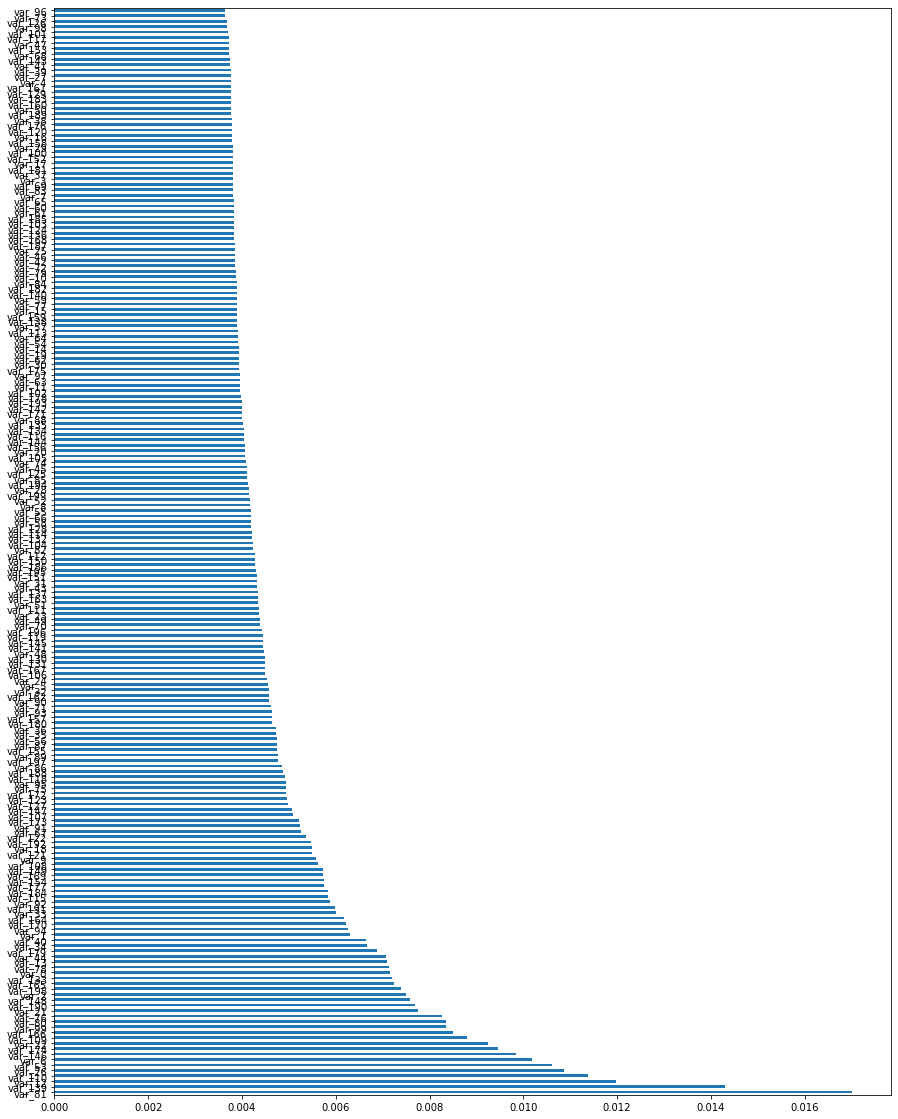

In [ ]:
feat_importance.nlargest(200).plot(kind='barh', figsize=(15,20))
plt.show()